In [1]:
from mytorch.train import *
from mytorch.HT import *

# Neural Networks and Tensor analysis
Artificial intelligence (AI) has become increasingly important in today's world, playing an important role in nearly every aspect of modern life. At the core of AI are neural networks, which form the foundation of many deep learning applications. Numerous libraries, such as [**PyTorch**](https://pytorch.org/) and [**TensorFlow**](https://www.tensorflow.org/), have been developed to facilitate the construction and training of various neural networks. However, few users of these frameworks fully understand their underlying mechanisms. Therefore, implementing a **PyTorch**-like library from scratch is a good practice to gain a deeper understanding of how neural networks work.

For our custom deep learning library **MyTorch**, the primary task is to implement backpropagation, the fundamental algorithm to train neural networks. The effectiveness of backpropagation was first demonstrated in the paper ["Learning representations by back-propagating errors"](https://www.iro.umontreal.ca/~vincentp/ift3395/lectures/backprop_old.pdf). In this project, we build and train a linear model and a convolutional neural network, two of the most common deep learning models, to demonstrate our library's functionality.

Furthermore, in the paper ["On the Expressive Power of Deep Learning: A Tensor Analysis"](https://arxiv.org/abs/1509.05009), the authors established an equivalence between convolutional neural networks and tensor decompositions, proposing model architectures that aligned with the tensor decompositions. While their work remains theoretical, this project extends it by implementing one of their proposed models to empirically evaluate its performance.

## Table of Contents  
1. [Linear Model](#1.-Linear-Model)
   1. [Forward Pass](#1.1.-Forward-Pass)
   2. [Backward Pass](#1.2.-Backward-Pass)
   3. [Training](#1.3.-Training)
   4. [Multilayer Perceptron (MLP)](#1.4.-Multilayer-Perceptron-(MLP))
2. [Convolutional Neural Network](#2.-Convolutional-Neural-Network)
   1. [2D Convolution Operation](#2.1.-2D-Convolution-Operation)
   2. [Forward Pass](#2.2.-Forward-Pass)
   3. [Backward Pass](#2.3.-Backward-Pass)
   4. [Training](#2.4.-Training)
3. [Convolutional Arithmetic Circuits](#3.-Convolutional-Arithmetic-Circuits)
   1. [Tensor Decompositions](#3.1.-Tensor-Decompositions)
      1. [Canonical Polyadic (CP) Decomposition](#3.1.1.-Canonical-Polyadic-(CP)-Decomposition)
      2. [Tucker Decomposition](#3.1.2.-Tucker-Decomposition)
      3. [Hierarchical Tucker (HT) Decomposition](#3.1.3.-Hierarchical-Tucker-(HT)-Decomposition)
   2. [CP Model](#3.2.-CP-Model)
   3. [HT Model](#3.3.-HT-Model)
   4. [Training](#3.4.-Training)
4. [Outlook](#4.-Outlook)
5. [References](#5.-References)

## 1. Linear Model
Linear model is one of the most fundamental machine learning models that is often the building block for many deep neural networks. Its objective is to capture a linear relation between the input samples and target values.

In this chapter we will cover the following topics:
- Computation of the forward pass
- Gradients in the backward pass
- Training on linearly separable dataset
- [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) for non-linearly separable dataset

### 1.1. Forward Pass
Essentially, its forward pass is a [multivariate linear regression](https://en.wikipedia.org/wiki/General_linear_model), given input samples $X$, a weight matrix $W$ and a bias vector $b$, it can be formulated as:
$$
\hat{Y}(i,\, j) = b(j) + X(i,\, 0) W(0,\, j) + X(i,\, 1) W(1,\, j) + \cdots + X(i,\, N_{\text{in}} - 1) W(N_{\text{in}} - 1,\, j) = b(j) + \sum_{k=0}^{N_{\text{in}} - 1} X(i,\, k) W(k,\, j) = (XW + b)(i,\, j)
$$
- $X \in \mathbb{R}^{B \times N_{\text{in}}}$: Input samples, where $B$ is the batch size, $N_{\text{in}}$ is the number of input features
- $W \in \mathbb{R}^{N_{\text{in}} \times N_{\text{out}}}$: Weight matrix, where $N_{\text{out}}$ is the number of output features
- $b \in \mathbb{R}^{N_{\text{out}}}$: Bias vector
- $\hat{Y} \in \mathbb{R}^{B \times N_{\text{out}}}$: Predicted values

In other words, its forward pass is simply a matrix multiplication between the input samples $X$ and the weight matrix $W$, followed by an addition of the bias vector $b$.

### 1.2. Backward Pass
As for the backward pass, three gradients are required, $\dfrac{\partial L}{\partial X}$, $\dfrac{\partial L}{\partial W}$ and $\dfrac{\partial L}{\partial b}$, where $L$ is the loss function as a criterion for how good the predicted values are comparing with the target values $Y$. Obviously, $\dfrac{\partial L}{\partial b}$ is a vector of ones, so let's start with $\dfrac{\partial L}{\partial X}$, according to the chain rule we have:
\begin{align*}
\dfrac{\partial L}{\partial X(p,\, q)} &= \sum_{i=0}^{B - 1} \sum_{j=0}^{N_{\text{out}} - 1} \dfrac{\partial L}{\partial \hat{Y}(i,\, j)} \cdot \dfrac{\partial \hat{Y}(i,\, j)}{\partial X(p,\, q)} \\
&= \sum_{i=0}^{B - 1} \sum_{j=0}^{N_{\text{out}} - 1} \dfrac{\partial L}{\partial \hat{Y}(i,\, j)} \cdot \dfrac{\partial \big(b(j) + \sum_{k=0}^{N_{\text{in}} - 1} X(i,\, k) W(k,\, j)\big)}{\partial X(p,\, q)} \\
&= \sum_{i=0}^{B - 1} \sum_{j=0}^{N_{\text{out}} - 1} \dfrac{\partial L}{\partial \hat{Y}(i,\, j)} \cdot \sum_{k=0}^{N_{\text{in}} - 1} W(k,\, j) \cdot \dfrac{\partial X(i,\, k)}{\partial X(p,\, q)} \\
&= \sum_{i=0}^{B - 1} \sum_{j=0}^{N_{\text{out}} - 1} \dfrac{\partial L}{\partial \hat{Y}(i,\, j)} \cdot \sum_{k=0}^{N_{\text{in}} - 1} W(k,\, j) \cdot \delta(i,\, p) \cdot \delta(k,\, q)\\
&= \sum_{j=0}^{N_{\text{out}} - 1} \dfrac{\partial L}{\partial \hat{Y}(p,\, j)} \cdot W(q,\, j) \\
&= \sum_{j=0}^{N_{\text{out}} - 1} \dfrac{\partial L}{\partial \hat{Y}(p,\, j)} \cdot W^{\top}(j,\, q) \\
\end{align*}

Therefore, we obtain $\dfrac{\partial L}{\partial X} = \dfrac{\partial L}{\partial \hat{Y}} W^{\top}$, and $\dfrac{\partial L}{\partial W} = X^{\top} \dfrac{\partial L}{\partial \hat{Y}}$ can be derived in a similar way. The backward-pass computation in our implementation follows these equations.  Given a simple loss function $L$ as a sum of all entries in $\hat{Y}$, we then run our implementation and verify both gradients with those computed by **PyTorch**:

In [2]:
torch.manual_seed(0)
X_shape = (5, 4)
W_shape = (4, 2)
X = torch.randint(1, 4, size=X_shape, dtype=torch.float32, requires_grad=True)
X.retain_grad()
W = torch.randint(1, 4, size=W_shape, dtype=torch.float32, requires_grad=True)
W.retain_grad()
pytorch_output = X @ W
mytorch_output = Tensor(X.flatten().tolist(), shape=X_shape, history=History()) @ Tensor(W.flatten().tolist(), shape=W_shape, history=History())
mytorch_output.backward()
pytorch_output.sum().backward()
print('=== ∂L/∂X ===')
print('MyTorch:', mytorch_output.history.parents[0].gradient.tolist())
print('\nPyTorch:', X.grad.tolist())
print('\n=== ∂L/∂W ===')
print('MyTorch:', mytorch_output.history.parents[1].gradient.tolist())
print('\nPyTorch:', W.grad.tolist())

=== ∂L/∂X ===
MyTorch: [[6.0, 6.0, 6.0, 5.0], [6.0, 6.0, 6.0, 5.0], [6.0, 6.0, 6.0, 5.0], [6.0, 6.0, 6.0, 5.0], [6.0, 6.0, 6.0, 5.0]]

PyTorch: [[6.0, 6.0, 6.0, 5.0], [6.0, 6.0, 6.0, 5.0], [6.0, 6.0, 6.0, 5.0], [6.0, 6.0, 6.0, 5.0], [6.0, 6.0, 6.0, 5.0]]

=== ∂L/∂W ===
MyTorch: [[9.0, 9.0], [5.0, 5.0], [13.0, 13.0], [10.0, 10.0]]

PyTorch: [[9.0, 9.0], [5.0, 5.0], [13.0, 13.0], [10.0, 10.0]]


### 1.3. Training
In this section, we train a linear model with a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) output activation function for classification on different datasets to demonstrate its performance and limitations. First, let's consider a dataset of random 2D coordinates, the coordinates above the diagonal $y = x$ are labeled with $1$, while the rest are labeled with $0$, so it is a linearly separable dataset and the goal is to find the true decision boundary $y = x$. The training process is shown as follows:

epoch: 100/500, acc: 98.00%, loss: 0.1183
epoch: 200/500, acc: 99.00%, loss: 0.0402
epoch: 300/500, acc: 99.00%, loss: 0.0229
epoch: 400/500, acc: 99.00%, loss: 0.0150
epoch: 500/500, acc: 100.00%, loss: 0.0104

test acc = 100.00%


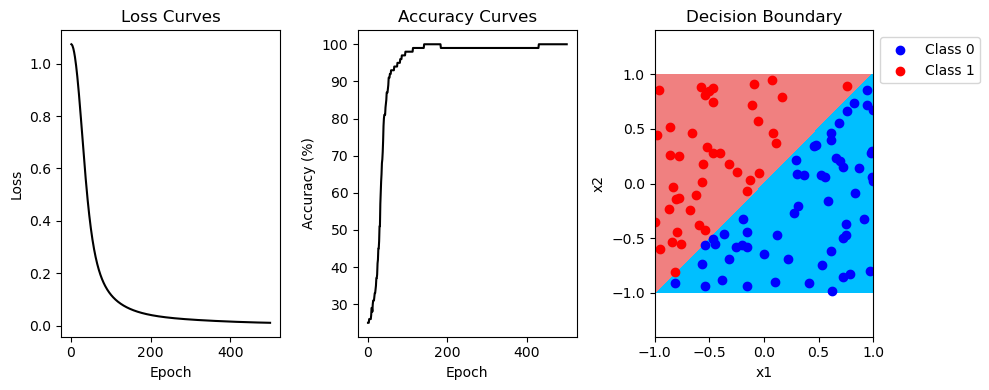

In [3]:
train(model = Linear(2, 1), dataset = diagonal(pts = 100), optim = 'SGD', epochs = 500, lr = 0.01)

The linear model was trained for $500$ epochs. As shown in the training log and the curves, the loss decreased consistently from above $1.0$ in the early epochs to $0.0104$ by the end of training, while the accuracy improved correspondingly from below $30$% to $100$%. The trained model achieved $100$% accuracy on the test dataset as well, indicating good generalization. The contour plot shows that the learned decision boundary aligns well with the true decision boundary $y = x$, confirming that the linear model has successfully captured the underlying linear relationship between the points and their labels. Overall, the training process converged rapidly and achieved perfect classification on both training and test datasets.

### 1.4. Multilayer Perceptron (MLP)
However, a linear model can only solve linearly separable classification tasks. For more complex non-linear tasks, we can still build on the linear models by combining them with non-linear activation functions in between such as the [rectified linear unit](https://en.wikipedia.org/wiki/Rectified_linear_unit). By stacking multiple linear models with activation functions, we obtain a MLP which is capable of finding non-linear decision boundaries. To illustrate this, consider a dataset of random 2D coordinates. points satisfy $x^2 + y^2 < 0.5$ are labeled with $0$, while the rest are labeled with $1$, This dataset is not linearly separable and the goal is to find the true decision boundary  $x^2 + y^2 = 0.5$. The training process is shown as follows:

epoch: 100/500, acc: 86.00%, loss: 0.2987
epoch: 200/500, acc: 96.00%, loss: 0.1272
epoch: 300/500, acc: 98.00%, loss: 0.0949
epoch: 400/500, acc: 99.00%, loss: 0.0190
epoch: 500/500, acc: 100.00%, loss: 0.0015

test acc = 100.00%


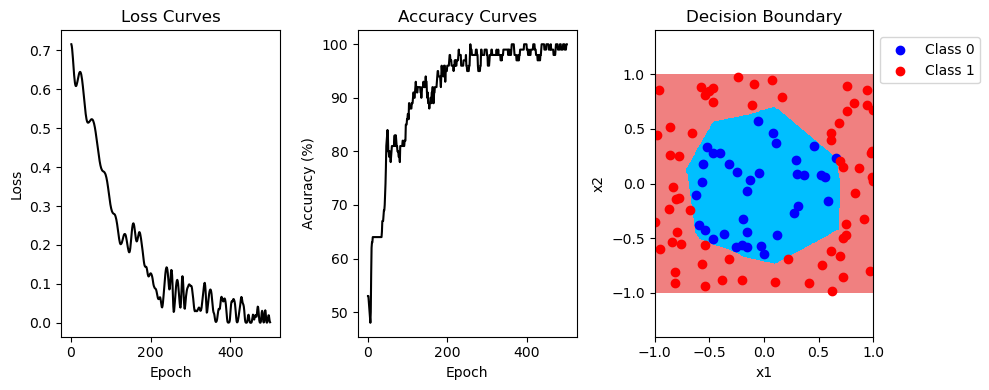

In [4]:
train(model = MLP(2, 10, 1), dataset = circle(pts = 100), optim = 'SGD', epochs = 500, lr = 0.01)

The MLP was trained for $500$ epochs. The loss decreased from above $0.6$ to around $0.001$, while the accuracy improved from below $50$% to $100$%. The trained model achieved $100$% accuracy on the test dataset. The contour plot shows that the MLP managed to find the true non-linear decision boundary $x^2 + y^2 = 0.5$, proving its ability to capture the underlying non-linear relationship. Overall, the training process converged with minor fluctuations and achieved good classification on both the training and test datasets.

Furthermore, we train the MLP on a more complex 2D dataset imitates a spiral, the training process is as follows:

epoch: 100/400, acc: 75.00%, loss: 0.4777
epoch: 200/400, acc: 97.00%, loss: 0.0627
epoch: 300/400, acc: 98.00%, loss: 0.0335
epoch: 400/400, acc: 99.00%, loss: 0.0326

test acc = 100.00%


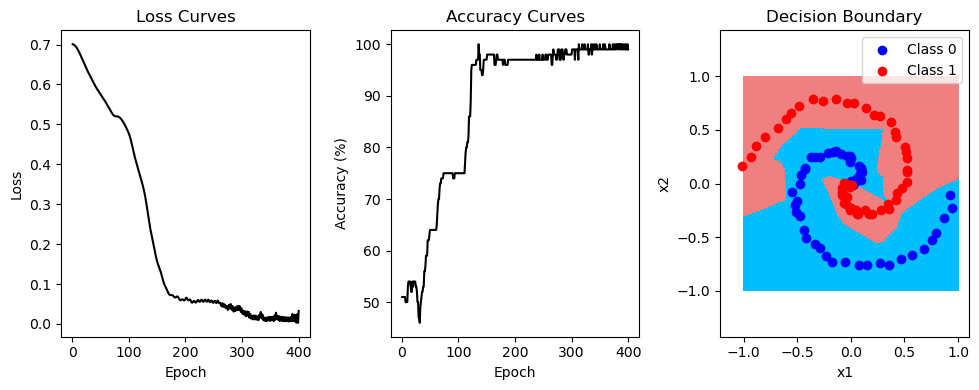

In [5]:
train(model = MLP(2, 10, 1), dataset = spiral(pts = 100), optim = 'SGD', epochs = 400, lr = 0.01)

The MLP was trained for $400$ epochs. The loss decreased from above $0.6$ in the early epochs to around $0.03$ by the end of training, while the accuracy improved correspondingly from below $50$% to $99$%. The trained model achieved $100$% accuracy on the test dataset. The contour plot again shows that the MLP managed to find the true non-linear decision boundary.

## 2. Convolutional Neural Network
[Convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN or ConvNet) is a well-established deep learning model. It specializes in processing spatially structured data like images. Its most notable feature is its use of convolutional kernels or filters. Kernels carry the trainable weights of the model, they go over the images and generates feature maps that capture some certain features of the original images, and they will be optimized during the training.

This design is actually inspired by the human visual system, each kernel in CNN serves as a visual neuron, while every neuron can only detect a small part of the visual field that is its [receptive field](https://en.wikipedia.org/wiki/Receptive_field). Furthermore, neurophysiologists [David H. Hubel](https://en.wikipedia.org/wiki/David_H._Hubel) and [Torsten Wiesel](https://en.wikipedia.org/wiki/Torsten_Wiesel) have revealed that human visual system is hierarchical, low-level neurons detect simple features like edges, lines or circles, while higher-level neurons integrate the information in order to recognize more complex patterns like cars, houses or people.

Compare to other deep learning model, CNN is known for its shift invariance, which means it doesn't matter where a certain pattern like a car appears in the image, it is able to recognize it. Another advantage of CNN is that it often requires fewer parameters due to its shared-weight architecture as the same kernel is reused for the whole image, unlike linear model that every pixel of the image is assigned with a unique parameter, which can lead to a very high memory-cost and problems like vanishing gradients or exploding gradients. For example, consider an input image of size 100 × 100 with 3 channels (RGB), each parameter of the next layer requires 100 × 100 × 3 = 30,000 weights in any fully connected neural network, while it only needs 10 × 10 × 3 = 300 weights in a CNN with a kernel size of 10 × 10.

In this chapter we will cover the following topics:
- Introduction of 2D convolution operation
- Algorithms and some linear algebra used in the forward pass
- Algorithms and some simple matrix calculus used in the backward pass
- Training on [**MNIST**](https://en.wikipedia.org/wiki/MNIST_database) dataset

### 2.1. 2D Convolution Operation
In functional analysis, [convolution](https://en.wikipedia.org/wiki/Convolution) is a mathematical operation that takes two functions $f(x)$ and $g(x)$, and produces a new function $(f * g)(x)$ by first reflecting one of the functions over the y-axis, then sliding it over the other function, summing the products of their values at each point where they overlap. For example, reflecting $g(x)$ gives $g(-x)$. Then, sliding $g(-x)$ over $f(x)$ by a displacement of $t$ and multiplying their values gives $f(x)g(t - x)$. Finally, summing the products by taking the integral gives us its definition:
$$
(f * g)(t) := \int_{-\infty}^\infty f(\tau) g(t - \tau) \, d\tau.
$$

However, in the field of deep learning, the term convolution is often used to refer to [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation). For example, CNN actually uses cross-correlation instead of convolution. although the two operations are very similar, the only difference is that cross-correlation does not involve function reflection. For continuous functions $f$ and $g$, cross-correlation is defined as:
$$
(f \star g)(t) := \int_{-\infty}^\infty f(\tau) g(t + \tau) \, d\tau.
$$

For consistency, we will continue to use convolution to refer to the operation used in CNN. Furthermore, since images and kernels can be viewed as discrete functions in 2D, the discrete 2D convolution is defined as:
$$
(I * K)(i, j) := \sum_{p=0}^{H_{\text{k}}-1} \sum_{q=0}^{W_{\text{k}}-1} I(i + p,\, j + q) K(p,\, q).
$$
- $H_{\text{k}}$: The height of the kernel
- $W_{\text{k}}$: The width of the kernel
- $I(i,\, j)$: The value of pixel $(i,\, j)$ in the image
- $K(p,\, q)$: The value of parameter $(p,\, q)$ in the kernel

2D convolution is the core mathematical operation in CNN. The kernel acts as a sliding window over the image, summing the element-wise products between the kernel and the corresponding pixels of the image, like taking a dot product after they are both vectorized. For example, given an image of shape $(5,\, 5)$ and a kernel of shape $(3,\, 3)$:
$$
I =
\begin{bmatrix}
0 & 1 & 1 & 1 & 0 \\
0 & 1 & 0 & 1 & 0 \\
0 & 1 & 1 & 1 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 1 & 1 & 1 & 0
\end{bmatrix},
\quad
K =
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
$$

As you can see, the tiny binary image resembles a handwritten digit $9$, while the kernel is randomly initialized with natural numbers. According to the equation above, we have:

\begin{align*}
(I * K)(0,\, 0) &=
\operatorname{vec}\left(
\begin{bmatrix}
0 & 1 & 1 \\
0 & 1 & 0 \\
0 & 1 & 1
\end{bmatrix}
\right)
\cdot
\operatorname{vec}\left(
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
\right) \\
&= \sum_{p=0}^{2} \sum_{q=0}^{2} I(p,\, q) K(p,\, q) \\
&= 27
\end{align*}


This is achieved simply by placing the kernel over the top-left corner of the image and calculating the dot product of their vectorized forms. Similarly, we can compute the value of $(I * K)(1,\, 1)$ by sliding the kernel to the right by one column and down by one row, we have:

\begin{align*}
(I * K)(1,\, 1) &=
\operatorname{vec}\left(
\begin{bmatrix}
1 & 0 & 1 \\
1 & 1 & 1 \\
0 & 0 & 1
\end{bmatrix}
\right)
\cdot
\operatorname{vec}\left(
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
\right) \\
&= \sum_{p=0}^{2} \sum_{q=0}^{2} I(1 + p,\, 1 + q) K(p,\, q) \\
&= 28
\end{align*}


Finally, we can obtain the entire output of shape $(3,\, 3)$ as follows:
$$
I * K =
\begin{bmatrix}
27 & 40 & 23 \\
13 & 28 & 19 \\
22 & 36 & 23
\end{bmatrix}
$$


### 2.2. Forward Pass
The forward pass performs a 2D convolution. So far, the images we have used are 2D matrices of shape $(H,\, W)$. However, in real-world scenarios, input image is usually a 3D tensors of shape $(C_{\text{in}},\, H,\, W)$, where $C_{\text{in}}$ denotes the number of input channels. For example, a standard RGB image has three channels corresponding to red, green and blue. Therefore, the kernel must also be expanded from $(H_{\text{k}},\, W_{\text{k}})$ to shape $(C_{\text{in}},\, H_{\text{k}},\, W_{\text{k}})$ to match the channel of the input image. One kernel produces one output channel, so in order to generate a multichannel output, multiple kernels are used. In practice, multiple kernels form a 4D tensor of shape $(C_{\text{out}},\, C_{\text{in}},\, H_{\text{k}},\, W_{\text{k}})$, where $C_{\text{out}}$ denotes the number of output channels, and batched input images form a 4D tensor of shape $(B,\, C_{\text{in}},\, H,\, W)$, where $B$ denotes the batch size. The 2D convolution is then computed as:
$$
(I * K)(b,\, c_{\text{out}},\, i,\, j) =
\sum_{c_{\text{in}}=0}^{C_{\text{in}}-1}
\sum_{p=0}^{H_{\text{k}}-1}
\sum_{q=0}^{W_{\text{k}}-1}
I(b,\, c_{\text{in}},\, i + p,\, j + q)\,
K(c_{\text{out}},\, c_{\text{in}},\, p,\, q)
$$

Furthermore, 2D convolution has three main hyperparameters:
- Padding
- Dilation
- stride

Padding determines the number of additional rows and columns added around the original image, usually filled with zeros. It can enable kernels to capture more information near the image boundaries. For a padding of $(P_{\text{h}},\, P_{\text{w}})$ and an image of shape $(H,\, W)$, $P_{\text{h}}$ rows are added to both the top and bottom of the image, and $P_{\text{w}}$ columns are added to both the left and right sides of the image, producing a padded image of shape $(H + 2P_{\text{h}},\, W + 2P_{\text{w}})$. For example, if we apply a padding of $(1,\, 1)$ to the image $I$ shown above, we will get an $I_{\text{padded}}$ of shape $(7,\, 7)$:
$$
I_{\text{padded}} =
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 1 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 & 1 & 0 & 0 \\
0 & 0 & 1 & 1 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 1 & 1 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$

Dilation determines the number of zeros inserted between neighboring parameters of the original kernel. It can effectively enlarge the receptive field without increasing the number of parameters. For a dilation of $(D_{\text{h}},\, D_{\text{w}})$ and a kernel of shape $(H_{\text{k}},\, W_{\text{k}})$, $(D_{\text{h}} - 1)$ zeros are inserted between neighboring parameters in each column, and $(D_{\text{w}} - 1)$ zeros are inserted between neighboring parameters in each row, producing a dilated kernel of shape $(D_{\text{h}} H_{\text{k}} - D_{\text{h}} + 1,\, D_{\text{w}} W_{\text{k}} - D_{\text{w}} + 1)$. For example, if we apply a dilation of $(2,\, 2)$ to the kernel $K$ shown above, we will get a $K_{\text{dilated}}$ of shape $(5,\, 5)$:
$$
K_{\text{dilated}} =
\begin{bmatrix}
1 & 0 & 2 & 0 & 3 \\
0 & 0 & 0 & 0 & 0 \\
4 & 0 & 5 & 0 & 6 \\
0 & 0 & 0 & 0 & 0 \\
7 & 0 & 8 & 0 & 9
\end{bmatrix}
$$

Finally, stride determines how the kernel moves over the image. For an arbitrary stride of $(S_{\text{h}}, S_{\text{w}})$, giving padding $(P_{\text{h}}, P_{\text{w}})$ and dilation $(D_{\text{h}}, D_{\text{w}})$, the 2D convolution is then given by the following equation:
$$
(I * K)(b,\, c_{\text{out}},\, i,\, j) =
\sum_{c_{\text{in}}=0}^{C_{\text{in}}-1}
\sum_{p=0}^{H_{\text{k}}-1}
\sum_{q=0}^{W_{\text{k}}-1}
I(b,\, c_{\text{in}},\, i \cdot S_{\text{h}} + p \cdot D_{\text{h}} - P_{\text{h}},\, j \cdot S_{\text{w}} + q \cdot D_{\text{w}} - P_{\text{w}})\,
K(c_{\text{out}},\, c_{\text{in}},\, p,\, q)
$$

Where $I(b, c_{\text{in}}, h, w)=0$ when $h \notin [0,\, H]$ or $w \notin [0,\, W]$. So the shape of the output is given by:
$$
(B,\, C_{\text{out}},\, H_{\text{out}},\, W_{\text{out}})
$$
- $H_{\text{out}} = \left\lfloor \dfrac{H + 2 P_\text{h} - D_\text{h} (H_\text{k} - 1) - 1}{S_\text{h}} + 1 \right\rfloor$
- $W_{\text{out}} = \left\lfloor \dfrac{W + 2 P_\text{w} - D_\text{w} (W_\text{k} - 1) - 1}{S_\text{w}} + 1 \right\rfloor$

This is the equation we use to compute the 2D convolution in practice. Next, we use the Im2Col algorithms to implement the 2D convolution. Im2Col stands for image to column, is a widely used technique for speeding up 2D convolution by converting it into a **matrix multiplication**. As the name suggests, its core idea is to flatten the part of the input image that overlaps the kernel into a column, and kernels are flattened into rows. Then, 2D convolution is computed as a single matrix multiplication which can be highly optimized on modern hardware. For example, consider an input image $I$ of shape $(H = 5, W = 5)$ and a kernel $K$ of shape $(H_{\text{k}} = 3,\, W_{\text{k}} = 3)$:
$$
I =
\begin{bmatrix}
0 & 1 & 1 & 1 & 0 \\
0 & 1 & 0 & 1 & 0 \\
0 & 1 & 1 & 1 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 1 & 1 & 1 & 0
\end{bmatrix},
\quad
K =
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
$$
Sliding $K$ over $I$ with a stride of $(S_{\text{h}} = 2, S_{\text{w}} = 2)$ gives $4$ parts of the image $I$:
$$
I_1 =
\begin{bmatrix}
0 & 1 & 1 \\
0 & 1 & 0 \\
0 & 1 & 1
\end{bmatrix},
\quad
I_2 =
\begin{bmatrix}
1 & 1 & 0 \\
0 & 1 & 0 \\
1 & 1 & 0
\end{bmatrix},
\quad
I_3 =
\begin{bmatrix}
0 & 1 & 1 \\
0 & 0 & 0 \\
0 & 1 & 1
\end{bmatrix},
\quad
I_4 =
\begin{bmatrix}
1 & 1 & 0 \\
0 & 1 & 0 \\
1 & 1 & 0
\end{bmatrix}
$$
Then the $4$ matrices of shape $(3,\, 3)$ are flattened into $4$ column vectors of length $9$ and are stacked into a new matrix of shape $(9,\, 4)$. The kernel $K$ is flattened into a row vector of length $9$:
$$
K_{\text{new}} =
\begin{bmatrix}
1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9
\end{bmatrix},
\quad
I_{\text{new}} =
\begin{bmatrix}
0 & 1 & 0 & 1 \\
1 & 1 & 1 & 1 \\
1 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
1 & 1 & 0 & 1 \\
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 1 \\
1 & 1 & 1 & 1 \\
1 & 0 & 1 & 0
\end{bmatrix}
$$
Matrix multiplication between $K_{\text{new}}$ and $I_{\text{new}}$ gives a row vector of length $4$:
$$
K_{\text{new}}I_{\text{new}} =
\begin{bmatrix}
27 & 23 & 22 & 23
\end{bmatrix}
$$
Finally, since the expected output shape is $\left(\dfrac{H - H_{\text{k}}}{S_{\text{h}}} + 1 = 2,\, \dfrac{W - W_{\text{k}}}{S_{\text{w}}} + 1 = 2 \right)$, the row vector needs to be reshaped back to $(2,\, 2)$:
$$
\text{output} =
\begin{bmatrix}
27 & 23 \\
22 & 23
\end{bmatrix}
$$
This is a simple example with 2D input. In practice, consider batched input images $I$ of shape $(B,\, C_{\text{in}},\, H,\, W)$ and kernels $K$ of shape $(C_{\text{out}},\, C_{\text{in}},\, H_{\text{k}},\, W_{\text{k}})$, the output shape is then given by $(B,\, C_{\text{out}},\, H_{\text{out}},\, W_{\text{out}})$. First, $I$ is converted to $I_{\text{new}}$ of shape $(B,\, H_{\text{out}},\, W_{\text{out}},\, C_{\text{in}} \cdot H_{\text{k}} \cdot W_{\text{k}})$ and $K$ is converted to $K_{\text{new}}$ of shape $(C_{\text{out}},\, C_{\text{in}} \cdot H_{\text{k}} \cdot W_{\text{k}})$. Then, matrix multiplication $I_{\text{new}} K_{\text{new}}^{\mathsf{T}}$ gives a new tensor of shape $(B,\, H_{\text{out}},\, W_{\text{out}},\, C_{\text{out}})$. Finally, the new tensor needs to be permuted back to $(B,\, C_{\text{out}},\, H_{\text{out}},\, W_{\text{out}})$ to produce the output.

The Im2Col algorithm is used in our custom implementation of 2D convolution. To demonstrate our implementation, consider the following example:
- $I \in \mathbb{R}^{B \times C_{\text{in}} \times H \times W} = \mathbb{R}^{4 \times 3 \times 10 \times 10}$
- $K \in \mathbb{R}^{C_{\text{out}} \times C_{\text{in}} \times H_{\text{k}} \times W_{\text{k}}} = \mathbb{R}^{2 \times 3 \times 5 \times 5}$
- Stride: $(S_{\text{h}} = 2,\, S_{\text{w}} = 2)$
- Padding: $(P_{\text{h}} = 1,\, P_{\text{w}} = 1)$
- Dilation: $(D_{\text{h}} = 2,\, D_{\text{w}} = 2)$

### 2.3. Backward Pass
Most students who have studied 2D convolution know how its forward pass works. However, few of them understand the mechanism of its backward pass during backpropagation. In order to train a CNN, given a scalar-valued differentiable loss function $L$, two gradients are required, one is the gradient of $L$ with respect to the kernel parameters and the other one is the gradient of $L$ with respect to the input image pixels. The key takeaway from this section is that **the backward pass of 2D convolution also uses 2D convolution**. Let's start with the kernel parameters, recall the equation of 2D convolution:
$$
(I * K)(b,\, c_{\text{out}},\, i,\, j) =
\sum_{c_{\text{in}}=0}^{C_{\text{in}}-1}
\sum_{p=0}^{H_{\text{k}}-1}
\sum_{q=0}^{W_{\text{k}}-1}
I(b,\, c_{\text{in}},\, i \cdot S_{\text{h}} + p \cdot D_{\text{h}} - P_{\text{h}},\, j \cdot S_{\text{w}} + q \cdot D_{\text{w}} - P_{\text{w}})\,
K(c_{\text{out}},\, c_{\text{in}},\, p,\, q)
$$

Now that we want to compute $\dfrac{\partial L}{\partial K(c_{\text{out}},\, c_{\text{in}},\, p,\, q)}$, according to the chain rule, we have:


\begin{align*}
\dfrac{\partial L}{\partial K(c_{\text{out}},\, c_{\text{in}},\, p,\, q)} &= \sum_{b=0}^{B - 1} \sum_{i=0}^{H_{\text{out}} - 1} \sum_{j=0}^{W_{\text{out} - 1}} \dfrac{\partial L}{\partial (I * K)(b,\, c_{\text{out}},\, i,\, j)} \cdot \dfrac{\partial (I * K)(b,\, c_{\text{out}},\, i,\, j)}{\partial K(c_{\text{out}},\, c_{\text{in}},\, p,\, q)} \\
&= \sum_{b=0}^{B - 1} \sum_{i=0}^{H_{\text{out}} - 1} \sum_{j=0}^{W_{\text{out} - 1}} \dfrac{\partial L}{\partial (I * K)(b,\, c_{\text{out}},\, i,\, j)} \cdot I(b,\, c_{\text{in}},\, i \cdot S_{\text{h}} + p \cdot D_{\text{h}} - P_{\text{h}},\, j \cdot S_{\text{w}} + q \cdot D_{\text{w}} - P_{\text{w}}) \\
&= \sum_{b=0}^{B - 1} \sum_{i=0}^{H_{\text{out}} - 1} \sum_{j=0}^{W_{\text{out} - 1}} I(b,\, c_{\text{in}},\, p \cdot D_{\text{h}} + i \cdot S_{\text{h}} - P_{\text{h}},\, q \cdot D_{\text{w}} + j \cdot S_{\text{w}} - P_{\text{w}}) \cdot G(b,\, c_{\text{out}},\, i,\, j)
\end{align*}

- $G(b,\, c_{\text{out}},\, i,\, j)$: The upstream gradient

As you can see, this equation already shows some similarities with a 2D convolution. We just need to permute the first two indices of tensors $I$ and $G$, $\dfrac{\partial L}{\partial K}$ is permuted accordingly:
$$
\dfrac{\partial L}{\partial K(c_{\text{in}},\, c_{\text{out}},\, p,\, q)} = \sum_{b=0}^{B - 1} \sum_{i=0}^{H_{\text{out}} - 1} \sum_{j=0}^{W_{\text{out} - 1}} I(c_{\text{in}},\, b,\, p \cdot D_{\text{h}} + i \cdot S_{\text{h}} - P_{\text{h}},\, q \cdot D_{\text{w}} + j \cdot S_{\text{w}} - P_{\text{w}}) \cdot G(c_{\text{out}},\, b,\, i,\, j)
$$

Now this equation becomes a 2D convolution of the input images $I$ with the upstream gradient $G$ and its hyperparameters are as follows:
- Stride: $(D_{\text{h}},\, D_{\text{w}})$
- Padding: $(P_{\text{h}},\, P_{\text{w}})$
- Dilation: $(S_{\text{h}},\, S_{\text{w}})$
- Batch size: $C_{\text{in}}$
- Output channel: $C_{\text{out}}$
- Input channel: $B$

It is interesting to see that the dilation of the forward-pass 2D convolution actually becomes the stride of the backward-pass 2D convolution and how the other hyperparameters are related. Finally, in order to match the shape of the kernels $K$, we need to permute $\dfrac{\partial L}{\partial K(c_{\text{in}},\, c_{\text{out}},\, p,\, q)}$ back to $\dfrac{\partial L}{\partial K(c_{\text{out}},\, c_{\text{in}},\, p,\, q)}$. Formulating the backward pass as a 2D convolution allows us to utilize the highly optimized 2D convolution, instead of computing the gradients separately using some other algorithms.

Similarly, let's continue with the gradient of $L$ with respect to the input image pixels. First, we rewrite the equation of 2D convolution in terms of the dilated kernels $K_{\text{d}}$, so that the dilation $(D_{\text{h}},\, D_{\text{w}})$ becomes $(1,\, 1)$:
$$
(I * K_{\text{d}})(b,\, c_{\text{out}},\, i,\, j) =
\sum_{c_{\text{in}}=0}^{C_{\text{in}}-1}
\sum_{p=0}^{H_{\text{k}_\text{d}}-1}
\sum_{q=0}^{W_{\text{k}_\text{d}}-1}
I(b,\, c_{\text{in}},\, i \cdot S_{\text{h}} + p - P_{\text{h}},\, j \cdot S_{\text{w}} + q - P_{\text{w}})\,
K_{\text{d}}(c_{\text{out}},\, c_{\text{in}},\, p,\, q)
$$

Since a pixel of the input images is denoted by $I(b,\, c_{\text{in}},\, h,\, w)$, we have $h = i \cdot S_{\text{h}} + p - P_{\text{h}}$ and $w = j \cdot S_{\text{w}} + q - P_{\text{w}}$. Then the gradient can be computed as follows:

\begin{align*}
\dfrac{\partial L}{\partial I(b,\, c_{\text{in}},\, h,\, w)} &= \sum_{c_{\text{out}}=0}^{C_{\text{out}} - 1} \sum_{i=0}^{H_{\text{out}} - 1} \sum_{j=0}^{W_{\text{out} - 1}} \dfrac{\partial L}{\partial (I * K_{\text{d}})(b,\, c_{\text{out}},\, i,\, j)} \cdot \dfrac{\partial (I * K_{\text{d}})(b,\, c_{\text{out}},\, i,\, j)}{\partial I(b,\, c_{\text{in}},\, h,\, w)} \\
&= \sum_{c_{\text{out}}=0}^{C_{\text{out}} - 1} \sum_{i=0}^{H_{\text{out}} - 1} \sum_{j=0}^{W_{\text{out} - 1}} \dfrac{\partial L}{\partial (I * K_{\text{d}})(b,\, c_{\text{out}},\, i,\, j)} \cdot K_{\text{d}}(c_{\text{out}},\, c_{\text{in}},\, p,\, q) \\
&= \sum_{c_{\text{out}}=0}^{C_{\text{out}} - 1} \sum_{i=0}^{H_{\text{out}} - 1} \sum_{j=0}^{W_{\text{out} - 1}} K_{\text{d}}(c_{\text{out}},\, c_{\text{in}},\, h - i \cdot S_{\text{h}} + P_{\text{h}},\, w - j \cdot S_{\text{w}} + P_{\text{w}}) \cdot G(b,\, c_{\text{out}},\, i,\, j)
\end{align*}


We also need to permute the first two indices of tensors $K_{\text{d}}$, $\dfrac{\partial L}{\partial I}$ is permuted accordingly:
$$
\dfrac{\partial L}{\partial I(c_{\text{in}},\, b,\, h,\, w)} = \sum_{c_{\text{out}}=0}^{C_{\text{out}} - 1} \sum_{i=0}^{H_{\text{out}} - 1} \sum_{j=0}^{W_{\text{out} - 1}} K_{\text{d}}(c_{\text{in}},\, c_{\text{out}},\, h - i \cdot S_{\text{h}} + P_{\text{h}},\, w - j \cdot S_{\text{w}} + P_{\text{w}}) \cdot G(b,\, c_{\text{out}},\, i,\, j)
$$

According to the equation of 2D convolution, we would expect to get terms like $h + i$ and $w + j$, but instead we get $h - i$ and $w - j$. Therefore, an important trick hare is to rotate the upstream gradient $G$ by $180^{\circ}$ along its last two indices, denoted by $G_{\text{r}}$. An example of rotating a matrix by $180^{\circ}$ is as follows:

$$
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
\rightarrow
\begin{bmatrix}
9 & 8 & 7 \\
6 & 5 & 4 \\
3 & 2 & 1
\end{bmatrix}
$$
Therefore, after the rotation we have:

\begin{align*}
\dfrac{\partial L}{\partial I(c_{\text{in}},\, b,\, h,\, w)} &= \sum_{c_{\text{out}}=0}^{C_{\text{out}} - 1} \sum_{i=0}^{H_{\text{out}} - 1} \sum_{j=0}^{W_{\text{out} - 1}} K_{\text{d}}(c_{\text{in}},\, c_{\text{out}},\, h - i \cdot S_{\text{h}} + P_{\text{h}},\, w - j \cdot S_{\text{w}} + P_{\text{w}}) \cdot G_{\text{r}}(b,\, c_{\text{out}},\, (H_{\text{out}} - 1) - i,\, (W_{\text{out}} - 1) - j) \\
&= \sum_{c_{\text{out}}=0}^{C_{\text{out}} - 1} \sum_{i=0}^{H_{\text{out}} - 1} \sum_{j=0}^{W_{\text{out} - 1}} K_{\text{d}} \Bigg(c_{\text{in}},\, c_{\text{out}},\, h + (H_{\text{out}} - 1 - i) \cdot S_{\text{h}} - \bigg((H_{\text{out}} - 1) \cdot S_{\text{h}} - P_{\text{h}}\bigg) \\
&\quad ,\, w + (W_{\text{out}} - 1 - j) \cdot S_{\text{w}} - \bigg((W_{\text{out}} - 1) \cdot S_{\text{w}} - P_{\text{w}}\bigg)\Bigg) \cdot G_{\text{r}}\Bigg(b,\, c_{\text{out}},\, H_{\text{out}} - 1 - i,\, W_{\text{out}} - 1 - j\Bigg) \\
&= \sum_{c_{\text{out}}=0}^{C_{\text{out}} - 1} \sum_{i'=0}^{H_{\text{out}} - 1} \sum_{j'=0}^{W_{\text{out} - 1}} K_{\text{d}} \Bigg(c_{\text{in}},\, c_{\text{out}},\, h + i' \cdot S_{\text{h}} - \bigg((H_{\text{out}} - 1) \cdot S_{\text{h}} - P_{\text{h}}\bigg),\, w + j' \cdot S_{\text{w}} - \bigg((W_{\text{out}} - 1) \cdot S_{\text{w}} - P_{\text{w}}\bigg)\Bigg) \cdot G_{\text{r}}\Bigg(b,\, c_{\text{out}},\, i',\, j'\Bigg)
\end{align*}

- $i' = H_{\text{out}} - 1 - i$
- $j' = W_{\text{out}} - 1 - j$

This equation gives us the gradient of $L$ with respect to the input image pixels. It is a 2D convolution of the dilated kernels $K_{\text{d}}$ with the rotated upstream gradient $G_{\text{r}}$ and its hyperparameters are as follows:
- Stride: $(1,\, 1)$
- Padding: $\bigg((H_{\text{out}} - 1) \cdot S_{\text{h}} - P_{\text{h}},\, (W_{\text{out}} - 1) \cdot S_{\text{w}} - P_{\text{w}}\bigg)$
- Dilation: $(S_{\text{h}},\, S_{\text{w}})$
- Batch size: $C_{\text{in}}$
- Output channel: $B$
- Input channel: $C_{\text{out}}$

Finally, in order to match the shape of the input images $I$, we need to permute $\dfrac{\partial L}{\partial I(c_{\text{in}},\, b,\, h,\, w)}$ back to $\dfrac{\partial L}{\partial I(b,\, c_{\text{in}},\, h,\, w)}$.

Our implementation of the backward pass strictly follows the two equations of $\dfrac{\partial L}{\partial K}$ and $\dfrac{\partial L}{\partial I}$. Again, we run our implementation and verify both gradients with **PyTorch**:

In [6]:
torch.manual_seed(0)
I_shape = (2, 2, 3, 3)
K_shape = (2, 2, 2, 2)
stride = (2, 2)
padding = (1, 1)
dilation = (2, 2)
I = torch.randint(1, 4, size=I_shape, dtype=torch.float32, requires_grad=True)
I.retain_grad()
K = torch.randint(1, 4, size=K_shape, dtype=torch.float32, requires_grad=True)
K.retain_grad()
pytorch_output = torch.nn.functional.conv2d(I, K, stride=stride, padding=padding, dilation=dilation)
mytorch_output = MyConv2d.forward(Tensor(I.flatten().tolist(), shape=I_shape, history=History()), 
                           Tensor(K.flatten().tolist(), shape=K_shape, history=History()), stride=stride, padding=padding, dilation=dilation)
mytorch_output.backward()
pytorch_output.sum().backward()
print('=== ∂L/∂I ===')
print('MyTorch:', mytorch_output.history.parents[0].gradient.tolist())
print('\nPyTorch:', I.grad.tolist())
print('\n=== ∂L/∂K ===')
print('MyTorch:', mytorch_output.history.parents[1].gradient.tolist())
print('\nPyTorch:', K.grad.tolist())

=== ∂L/∂I ===
MyTorch: [[[[0.0, 0.0, 0.0], [0.0, 19.0, 0.0], [0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0], [0.0, 18.0, 0.0], [0.0, 0.0, 0.0]]], [[[0.0, 0.0, 0.0], [0.0, 19.0, 0.0], [0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0], [0.0, 18.0, 0.0], [0.0, 0.0, 0.0]]]]

PyTorch: [[[[0.0, 0.0, 0.0], [0.0, 19.0, 0.0], [0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0], [0.0, 18.0, 0.0], [0.0, 0.0, 0.0]]], [[[0.0, 0.0, 0.0], [0.0, 19.0, 0.0], [0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0], [0.0, 18.0, 0.0], [0.0, 0.0, 0.0]]]]

=== ∂L/∂K ===
MyTorch: [[[[5.0, 5.0], [5.0, 5.0]], [[2.0, 2.0], [2.0, 2.0]]], [[[5.0, 5.0], [5.0, 5.0]], [[2.0, 2.0], [2.0, 2.0]]]]

PyTorch: [[[[5.0, 5.0], [5.0, 5.0]], [[2.0, 2.0], [2.0, 2.0]]], [[[5.0, 5.0], [5.0, 5.0]], [[2.0, 2.0], [2.0, 2.0]]]]


### 2.4. Training
**MNIST** dataset is a large dataset of grayscale images of handwritten digits from $0$ to $9$. We train a simple CNN on a subset of **MNIST** dataset and the training process is as follows:

epoch: 1/10, acc: 56.88%, loss: 2.4686
epoch: 2/10, acc: 85.47%, loss: 0.9372
epoch: 3/10, acc: 87.81%, loss: 0.8370
epoch: 4/10, acc: 91.72%, loss: 0.4419
epoch: 5/10, acc: 96.56%, loss: 0.2430
epoch: 6/10, acc: 97.03%, loss: 0.1826
epoch: 7/10, acc: 98.44%, loss: 0.0951
epoch: 8/10, acc: 98.75%, loss: 0.0901
epoch: 9/10, acc: 98.75%, loss: 0.0975
epoch: 10/10, acc: 99.53%, loss: 0.0665


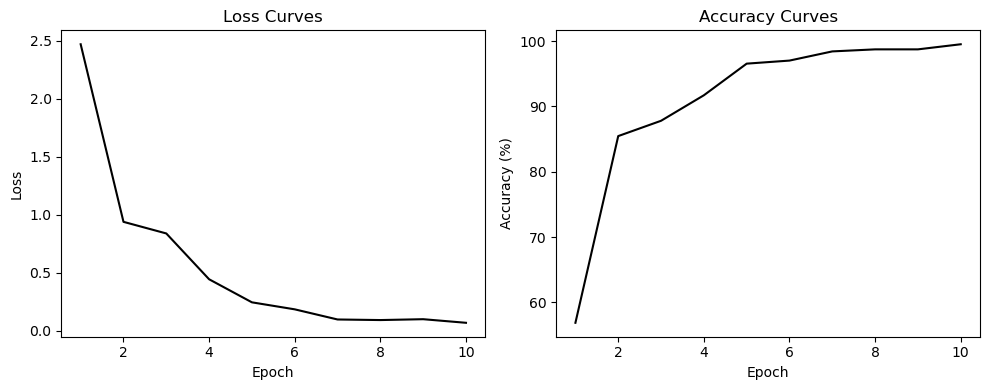

In [7]:
train_cnn(model = Conv2d(1, 10, 28), optim = 'Adagrad')

The CNN was trained for $10$ epochs. The loss decreased from above $2.0$ in the early epochs to $0.06$ by the end of training, while the accuracy improved from below $60$% to $99$%. Overall, the training process converged rapidly and achieved good classification on training dataset.

## 3. Convolutional Arithmetic Circuits
In the deep learning community, an ongoing discussion is the power of depth. Although numerous empirical evidences have shown that a deeper CNN is able to represent a complex data pattern more efficiently compare with a shallow one in terms of the number of parameters, there are only few theoretical proofs. In the paper ["On the Expressive Power of Deep Learning: A Tensor Analysis"](https://arxiv.org/abs/1509.05009), the authors used convolutional arithmetic circuits to establish a connection between CNNs and tensor decompositions. They demonstrated that a shallow CNN corresponds to [Canonical Polyadic (CP) decomposition](https://en.wikipedia.org/wiki/Tensor_rank_decomposition), while a deep CNN corresponds to [Hierarchical Tucker (HT) decomposition](https://link.springer.com/content/pdf/10.1007/s00041-009-9094-9.pdf). Therefore, established theorems and tools from the tensor community can be then used to analyze the CNNs.

In this chapter we will cover the following topics:
- Introduction to basic tensor decompositions
- CP model
- HT model
- Training HT model on **MNIST** dataset

### 3.1. Tensor Decompositions
Tensor decomposition is a mathematical technique that expresses a tensor as a series of tensors, it is a generalization of the matrix decomposition. its purpose is to uncover inherent structure, reduce storage and speed up computations.

#### 3.1.1. Canonical Polyadic (CP) Decomposition

For a tensor $\mathcal{X} \in \mathbb{R}^{M_1 \times M_2 \times \cdots \times M_N}$, the CP decomposition of $\mathcal{X}$ can be expressed as a sum of $R$ rank-$1$ tensors:
$$
\mathcal{X} = \sum_{r=1}^{R}
\lambda_{r} \cdot
\mathbf{v}^{(r,\, 1)} \otimes
\mathbf{v}^{(r,\, 2)} \otimes
\cdots \otimes
\mathbf{v}^{(r,\, N)}
$$
- $\mathbf{v}^{(r,\, i)} \in \mathbb{R}^{M_i},\, \lambda_{r} \in \mathbb{R}$

Or it can be written element-wise as:
$$
\mathcal{X}_{d_1 \dots d_{N}} = \sum_{r=1}^{R}
\lambda_{r} \cdot
v^{(r,\, 1)}_{d_1} \cdot
v^{(r,\, 2)}_{d_2}
\cdots
v^{(r,\, N)}_{d_N}
$$
- $v^{(r,\, i)}_{d_i} \in \mathbb{R}$

Where $\otimes$ denotes the tensor product. For two tensors $\mathcal{A}$ and $\mathcal{B}$ of orders $P$ and $Q$ respectively, $(\mathcal{A} \otimes \mathcal{B})$ is a tensor of order $P+Q$ defined element-wise as $(\mathcal{A} \otimes \mathcal{B})_{d_1 \dots d_{P+Q}} = \mathcal{A}_{d_1 \dots d_P} \cdot \mathcal{B}_{d_{P+1} \dots d_{P+Q}}$. Tensor product becomes outer product when both operands are vectors. $R$ is the CP-rank of $\mathcal{X}$ which is the minimum number of rank-$1$ tensors needed for the decomposition. A rank-$1$ tensor is one that can be expressed as an outer product of a set of vectors, like $\bigotimes_{i=1}^{N} \mathbf{v}^{(i)}$.

#### 3.1.2. Tucker Decomposition
We will see that the [Tucker decomposition](https://en.wikipedia.org/wiki/Tucker_decomposition) is nothing but a generalization of the CP decomposition. The Tucker decomposition of tensor $\mathcal{X}$ is defined as:
$$
\mathcal{X}
= \mathcal{G}
\times_1 U^{(1)}
\times_2 U^{(2)}
\times_3 \cdots
\times_N U^{(N)}
$$
- $U^{(i)} \in \mathbb{R}^{M_i \times R_i},\, \mathcal{G} \in \mathbb{R}^{R_1 \times R_2 \times \cdots \times R_N}$

where $\mathcal{G}$ is the core tensor, which is typically smaller than the original tensor $\mathcal{X}$ while still capturing its most significant structural information. Each $U^{(i)}$ is a factor matrix that maps $\mathcal{G}$ back into $\mathcal{X}$ along the $i$-th mode. $\mathcal{G} \times_i U^{(i)}$ denotes the mode-$i$ product between $\mathcal{G}$ and $U^{(i)}$ which is the multiplication of each mode-$i$ fiber of $\mathcal{G}$ by $U^{(i)}$. For better understanding, We can rewrite the decomposition using tensor product as:
 
$$
\mathcal{X} =
\sum_{r_1=1}^{R_1}
\sum_{r_2=1}^{R_2}
\cdots
\sum_{r_N=1}^{R_N}
\mathcal{G}_{r_1,\, r_2, \dots,\, r_N}
\cdot
U^{(1)}_{:,\, r_1} \otimes
U^{(2)}_{:,\, r_2} \otimes
\cdots \otimes
U^{(N)}_{:,\, r_N}
$$
- $U^{(i)}_{:,\, r_i} \in \mathbb{R}^{M_i}$

Or element-wise as:
$$
\mathcal{X}_{d_1,\, d_2, \dots,\, d_{N}} =
\sum_{r_1=1}^{R_1}
\sum_{r_2=1}^{R_2}
\cdots
\sum_{r_N=1}^{R_N}
\mathcal{G}_{r_1,\, r_2, \dots,\, r_N}
\cdot
U^{(1)}_{d_1,\, r_1} \cdot
U^{(2)}_{d_2,\, r_2}
\cdots
U^{(N)}_{d_N,\, r_N}
$$
- $U^{(i)}_{d_i,\, r_i} \in \mathbb{R}$

By comparing the element-wise definitions of the CP and Tucker decompositions, we can observe that the CP decomposition is a special case of the Tucker decomposition when the core tensor $\mathcal{G}$ is hyper-diagonal, that is, when $R_1 = R_2 = \cdots = R_N = R$ and $\mathcal{G}_{r_1, r_2, \dots, r_N} \neq 0$ only if $r_1 = r_2 = \cdots = r_N = r$, we have:

$$
\mathcal{X}_{d_1,\, d_2, \dots,\, d_{N}} =
\sum_{r=1}^{R}
\mathcal{G}_{r,\, r, \dots,\, r}
\cdot
U^{(1)}_{d_1,\, r} \cdot
U^{(2)}_{d_2,\, r}
\cdots
U^{(N)}_{d_N,\, r}
$$


#### 3.1.3. Hierarchical Tucker (HT) Decomposition
HT decomposition is a further generalization of the Tucker decomposition which is designed to approximate certain tensors more efficiently by introducing a hierarchical structure. Consider the original tensor $\mathcal{X} \in \mathbb{R}^{M_1 \times M_2 \times \cdots \times M_N}$ which lives in the tensor product space:
$$
V = \bigotimes^{N}_{i=1} V^{(i)} = V^{(1)} \otimes V^{(2)} \otimes \cdots \otimes V^{(N)}
$$

Assume each vector space $V^{(i)} = \mathbb{R}^{M_i}$ is spanned by the basis
$$\{\mathbf{v}^{(i,\, \alpha)} \in \mathbb{R}^{M_i} : 1 \leq \alpha \leq M_i\}$$
Since our goal is to approximate $\mathcal{X}$ in a more compact way, we seek an approximation within a subspace $W \subset V$. For example, in Tucker decomposition, $W$ is constructed as the tensor product of subspaces $W^{(i)} \subset V^{(i)}$, we have:
$$
W = \bigotimes^{N}_{i=1} W^{(i)} = W^{(1)} \otimes W^{(2)} \otimes \cdots \otimes W^{(N)}
$$

Its core tensor is given by $\mathcal{G} \in \mathbb{R}^{R_1 \times R_2 \times \cdots \times R_N}$, where $R_i < M_i$ holds for most cases as we want to reduce the dimensions. This indicates that each subspace $W^{(i)}$ is spanned by:
$$\{\mathbf{w}^{(i,\, \beta)} \in \mathbb{R}^{M_i} : 1 \leq \beta \leq R_i\}$$
- $V^{(i)} \ni \mathbf{w}^{(i,\, \beta)} = \sum^{M_i}_{\alpha=1} a_{\alpha,\, \beta} \cdot \mathbf{v}^{(i,\, \alpha)}$
- $a_{\alpha,\, \beta} \in \mathbb{R}$

In general, we also want $\mathbf{w}^{(i,\, \beta)}$ to be linearly independent to avoid redundant vectors.

As for HT decomposition, the idea of seeking an approximation of $\mathcal{X}$ in a subspace $W \subset V$ is the same. However, the construction of $W$ is somewhat different, instead of taking $W = \bigotimes^{N}_{i=1} W^{(i)}$, the tensor products are applied hierarchically according to a binary tree structure. For simplicity, we consider order $N=2^L \ge 2$, where $L$ is the number of layers in the binary tree, use $V^{(l,\, i)}$ to denote the $i$-th vector space at the $l$-th layer, we have:
$$
V = \bigotimes^{N}_{i=1} V^{(0,\, i)}
$$
For each $V^{(0,\, i)}$, we define subspaces $W^{(0,\,i)} \subset V^{(0,\,i)}$ for $1 \le i \le N$, and by taking their tensor product, we get:
$$
V \supset V^{(0)} = \bigotimes^{N}_{i=1} W^{(0,\, i)}
$$
Again we define subspaces $W^{(1,\, i)} \subset V^{(1,\, i)} = W^{(0,\, 2i-1)} \otimes W^{(0,\, 2i)}$ for $1 \le i \le \frac{N}{2}$, we get:
$$
V^{(0)} \supset V^{(1)} = \bigotimes^{\frac{N}{2}}_{i=1} W^{(1,\, i)}
$$
Similarly, at $l$-th layer, we define subspaces $W^{(l,\, i)} \subset V^{(l,\, i)} = W^{(l-1,\, 2i-1)} \otimes W^{(l-1,\, 2i)}$ for $1 \le i \le \frac{N}{2^l}$, we get:
$$
V^{(l-1)} \supset V^{(l)} = \bigotimes^{\frac{N}{2^l}}_{i=1} W^{(l,\, i)}
$$
Finally, at $L$-th layer, where $L=\log_2 N$, we define a subspace $W^{(L,\, 1)} \subset V^{(L,\, 1)} = W^{(L-1,\, 1)} \otimes W^{(L-1,\, 2)}$, we get:
$$
V^{(L-1)} \supset V^{(L)} = W^{(L,\, 1)}
$$
So we managed to hierarchically construct a subspace $V^{(L)} \subset V$ in which we can find an approximation of $\mathcal{X}$ according to the HT decomposition.

Furthermore, in order to derive a HT model in the next section, the representation of vector $\mathbf{v}^{(l,\, i,\, \gamma)} \in V^{(l,\, i)}$ is of interest. Assume subspace $W^{(l-1,\, i)}$ is spanned by the basis:
$$
\{\phi^{(l-1,\, i,\, \theta)}:1 \le \theta \le R^{(l-1,\, i)}\}
$$
- $\text{dim}(W^{(l-1,\, i)})=R^{(l-1,\, i)}$
- $\text{order}(\phi^{(l-1,\, i,\, \theta)})=2^{l-1}$

Then the tensor product space $V^{(l,\, i)}=W^{(l-1,\, 2i-1)} \otimes W^{(l-1,\, 2i)}$ of dimension $R^{(l-1,\, 2i-1)} \cdot R^{(l-1,\, 2i)}$ has the canonical basis:
$$
\{\phi^{(l-1,\, 2i-1,\, \alpha)} \otimes \phi^{(l-1,\, 2i,\, \beta)}:1 \le \alpha \le R^{(l-1,\, 2i-1)},\, 1 \le \beta \le R^{(l-1,\, 2i)}\}
$$
Therefore, vector $\mathbf{v}^{(l,\, i,\, \gamma)} \in V^{(l,\, i)}$ can be represented as a linear combination of the basis tensors with core matrix $A^{(l,\, i,\, \gamma)}=\left(a^{(l,\, i,\, \gamma)}_{\alpha,\, \beta}\right) \in \mathbb{R}^{R^{(l-1,\, 2i-1)} \times R^{(l-1,\, 2i)}}$:
$$
\mathbf{v}^{(l,\, i,\, \gamma)} = \sum^{R^{(l-1,\, 2i-1)}}_{\alpha=1} \sum^{R^{(l-1,\, 2i)}}_{\beta=1} a^{(l,\, i,\, \gamma)}_{\alpha,\, \beta} \cdot \phi^{(l-1,\, 2i-1,\, \alpha)} \otimes \phi^{(l-1,\, 2i,\, \beta)}
$$

### 3.2. CP Model
CP model is a **convolutional arithmetic circuit** implementing CP decomposition. The idea is to represent the coefficient tensor of a shallow CNN as a CP decomposition. The CP model can be constructed as follows:

For a classic image classification task with labels $\{1, \cdots , Y\}$. First, we first preprocess the input images, each input image is divided into a collection of $N$ smaller vectorized patches of length $s$, producing:
$$X \in \mathbb{R}^{N \times s}$$
Then, scalar-valued representation functions $\{f_{\theta_1}, \cdots, f_{\theta_M} : \mathbb{R}^s \rightarrow \mathbb{R\}}$ are applied to each row of $X$, producing the representation matrix:
$$F \in \mathbb{R}^{N \times M}$$
- $F_{i,\, d} = f_{\theta_d}(X_{i,\, :})$

Next, a $1 \times 1$ convolution with $Z$ output channels is applied to $F$ without weight sharing, meaning that each row of $F$ is assigned with a distinct kernel $\mathbf{a}^{(z,\, i)} \in \mathbb{R}^M$ for each output channel $z$, producing:
$$C \in \mathbb{R}^{N \times Z}$$
- $C_{i,\, z} = \langle \mathbf{a}^{(z,\, i)},\, F_{i,\, :} \rangle$

The convolution is followed by a global product pooling, producing a vector:
$$\mathbf{p} \in \mathbb{R}^Z$$
- $p_z = \prod^N_{i=1} C_{i,\, z}$

Finally, the vector $\mathbf{p}$ is fed into a dense linear layer with weights $\mathbf{a}^{(y)} \in \mathbb{R}^Z$ and no biases, producing an output vector:
$$\mathbf{o} \in \mathbb{R}^Y$$
- $o_y = \langle \mathbf{a}^{(y)},\, \mathbf{p} \rangle$
- $y \in \{1, \cdots , Y\}$

In the CP model, each output component $o_y$ can be expressed as a compact score function:
$$
h_y(X) =
\sum_{d_1, \ldots, d_N = 1}^{M}
\mathcal{A}^{(y)}_{d_1, \ldots, d_N}
\prod_{i=1}^{N}
f_{\theta_{d_i}}(X_{i,\, :})
$$
Where the coefficient tensor $\mathcal{A}^{(y)} \in \mathbb{R}^{\underbrace{M \times \cdots \times M}_{N}}$ is constructed from previous $\mathbf{a}^{(z,\, i)}$ and $\mathbf{a}^{(y)}$ via a CP decomposition:

\begin{align*}
\mathcal{A}^{(y)} &= \sum_{z=1}^{Z} a^{(y)}_z \cdot \mathbf{a}^{(z,\,1)} \otimes \cdots \otimes \mathbf{a}^{(z,\,N)} \\
\mathcal{A}^{(y)}_{d_1, \ldots, d_N} &= \sum_{z=1}^{Z} a^{(y)}_z \cdot a^{(z,\,1)}_{d_1} \cdots a^{(z,\,N)}_{d_N}
\end{align*}

If we substitute $\mathcal{A}^{(y)}_{d_1, \ldots, d_N}$ in the score function, we have:
\begin{align*}
h_y(X) &=
\sum_{d_1, \ldots, d_N = 1}^{M}
\Bigg(\sum_{z=1}^{Z} a^{(y)}_z \cdot a^{(z,\,1)}_{d_1} \cdots a^{(z,\,N)}_{d_N}\Bigg)
\prod_{i=1}^{N}
f_{\theta_{d_i}}(X_{i,\, :}) \\
&=
\sum_{d_1, \ldots, d_N = 1}^{M}
\sum_{z=1}^{Z} a^{(y)}_z \prod_{i=1}^{N} a^{(z,\,i)}_{d_i} f_{\theta_{d_i}}(X_{i,\, :}) \\
&=
\sum_{z=1}^{Z} a^{(y)}_z
\sum_{d_1, \ldots, d_N = 1}^{M} \prod_{i=1}^{N} a^{(z,\,i)}_{d_i} f_{\theta_{d_i}}(X_{i,\, :}) \\
&=
\sum_{z=1}^{Z} a^{(y)}_z
\prod_{i=1}^{N} \Bigg(\sum_{d = 1}^{M} a^{(z,\,i)}_{d} f_{\theta_{d}}(X_{i,\, :})\Bigg) \\
\end{align*}

### 3.3. HT Model
Similarly, HT model is a **convolutional arithmetic circuit** implementing HT decomposition. The idea is to represent the coefficient tensor of a deep CNN as a HT decomposition. HT model has a similar structure to the CP model, but it incorporates $L=\log_2 N$ hidden layers instead of just one, and $N$ is assumed to be a power of $2$. Each hidden layer consists of a $1 \times 1$ convolution followed by a pooling with a kernel of length $2$.

So we start with the same representation matrix $F \in \mathbb{R}^{N \times M}$. In each hidden layer $l$, where $0 \le l \le L-1$, a $1 \times 1$ convolution with $r_l$ output channels is applied to $F$ using kernels $\mathbf{a}^{(l,\, \gamma,\, i)} \in \mathbb{R}^M$ without weight sharing, producing:
$$C^{(l)} \in \mathbb{R}^{\frac{N}{2^l} \times r_l}$$
- $C^{(l)}_{i,\, \gamma} = \langle \mathbf{a}^{(l,\, \gamma,\, i)},\, F_{i,\, :} \rangle$

Followed by a pooling with a kernel of length $2$ which halves the height of the input, producing:
$$P^{(l)} \in \mathbb{R}^{\frac{N}{2^{l+1}} \times r_l}$$
- $P^{(l)}_{i,\, \gamma} = C^{(l)}_{2i-1,\, \gamma} \cdot C^{(l)}_{2i,\, \gamma}$

Then, after the hidden layer $L-1$, we will obtain a vector $P^{(L-1)} \in \mathbb{R}^{r_{L-1}}$, and feed it into a dense linear layer with weights $\mathbf{a}^{(L,\, y)} \in \mathbb{R}^{r_{L-1}}$ and no biases. Producing an output vector:
$$\mathbf{o} \in \mathbb{R}^Y$$
- $o_y = \langle \mathbf{a}^{(L,\, y)},\, P^{(L-1)} \rangle$
- $y \in \{1, \cdots , Y\}$

Therefore, we can use the same score function $h_y(X)$ as in the CP model, but with a HT decomposition of the coefficient tensor $\mathcal{A}^{(y)}$:
$$
\begin{aligned}
\phi^{(1,\, j,\, \gamma)} &= \sum_{\alpha=1}^{r_0} a^{(1,\, j,\, \gamma)}_{\alpha}\, \mathbf{a}^{(0,\, 2j-1,\, \alpha)} \otimes \mathbf{a}^{(0,\, 2j,\, \alpha)} \\
& \cdots \\
\phi^{(l,\, j,\, \gamma)} &= \sum_{\alpha=1}^{r_{l-1}} a^{(l,\, j,\, \gamma)}_{\alpha}\, \phi^{(l-1,\, 2j-1,\, \alpha)} \otimes \phi^{(l-1,\, 2j-1,\, \alpha)} \\
& \cdots \\
\phi^{(L-1,\, j,\, \gamma)} &= \sum_{\alpha=1}^{r_{L-2}} a^{(L-1,\, j,\, \gamma)}_{\alpha}\, \phi^{(L-2,\, 2j-1,\, \alpha)} \otimes \phi^{(L-2,\, 2j,\, \alpha)} \\
\mathcal{A}^{(y)} &= \sum_{\alpha=1}^{r_{L-1}} a^{(L,\, y)}_{\alpha}\, \phi^{(L-1,\ 1,\, \alpha)} \otimes \phi^{(L-1,\, 2,\, \alpha)}
\end{aligned}
$$

The above decomposition is a special case of the HT decomposition presented in ["A New Scheme for the Tensor Representation"](https://link.springer.com/content/pdf/10.1007/s00041-009-9094-9.pdf) by restricting the core matrices $A^{(l,\, i,\, \gamma)}$ to be diagonal, making it effectively a hierarchical CP decomposition.

### 3.4. Training
We implemented the HT model according to the equations above using **PyTorch** instead of **MyTorch** due to training speed concern. However, even with **PyTorch**, achieving a satisfactory accuracy requires a considerable amount of training time. Executing the following cell takes approximately $3$ minutes, depending on the hardware configuration. The result of training the HT model on a subset of **MNIST** dataset is as follows:

epoch: 10/100, loss: 1.0915, acc: 63.05%
epoch: 20/100, loss: 0.7243, acc: 79.06%
epoch: 30/100, loss: 0.5317, acc: 86.25%
epoch: 40/100, loss: 0.4311, acc: 88.59%
epoch: 50/100, loss: 0.5144, acc: 86.56%
epoch: 60/100, loss: 0.3756, acc: 88.20%
epoch: 70/100, loss: 0.4282, acc: 89.69%
epoch: 80/100, loss: 0.3315, acc: 91.17%
epoch: 90/100, loss: 0.3632, acc: 89.92%
epoch: 100/100, loss: 0.2695, acc: 93.05%


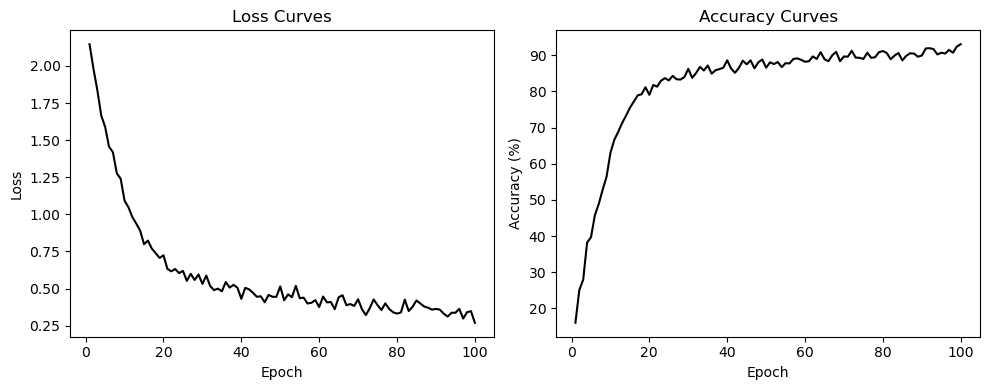

In [8]:
torch.manual_seed(0)
train_ht()

The HT model was trained for $100$ epochs. The loss decreased from above $2.0$ to below $0.3$, while the accuracy improved from around $30$% to $90$%. Both curves are relatively smooth, demonstrate a stable training process. However, the best accuracy $93.05$% is not very ideal, this is mostly due to the specific architecture of the HT model. 

## 4. Outlook
Although **MyTorch** has demonstrated stable training performance and achieved relatively high accuracy in previous experiments, the training speed remains too slow, which can make it impractical for tasks involving large models or huge data. Therefore, further improvements should revolve around accelerating computation. Firstly, optimizing matrix multiplication is crucial, as it is the underlying operation for most deep learning algorithms. Secondly, employing parallel computing can significantly improve the speed. Finally, at the hardware level, leveraging GPU instead of CPU can drastically reduce the training time, so adapting our current implementation to support CUDA would be a necessary and meaningful step.

Additionally, we have implemented a network referred to as the HT model with product pooling and linear point-wise activation. However, neither product pooling nor linear point-wise activation is a standard choice in the modern deep learning community. To address this, two of the original authors of the HT model further extended their work in their subsequent paper ["Convolutional Rectifier Networks as Generalized Tensor Decompositions"](https://arxiv.org/abs/1603.00162), introducing the convolutional rectifier network with max or average pooling and rectified linear activation. As the title suggests, a further extension of this project would involve implementing a convolutional rectifier network based on generalized tensor decomposition.

## 5. References
- Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. https://www.iro.umontreal.ca/~vincentp/ift3395/lectures/backprop_old.pdf
- deepkumarpatra. (23 Jul, 2025). Math behind Convolutional Neural Networks. https://www.geeksforgeeks.org/deep-learning/math-behind-convolutional-neural-networks/
- Jefkine. (5 Sep, 2016). Backpropagation in Convolutional Neural Networks. https://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/
- alka1974. (30 Sep, 2025). Mini-Batch Gradient Descent in Deep Learning. https://www.geeksforgeeks.org/deep-learning/mini-batch-gradient-descent-in-deep-learning/
- rahulsm27. (23 Jul, 2025). Kaiming Initialization in Deep Learning. https://www.geeksforgeeks.org/deep-learning/kaiming-initialization-in-deep-learning/
- Thomas Kurbiel. (Apr 22, 2021). Derivative of the Softmax Function and the Categorical Cross-Entropy Loss. https://medium.com/data-science/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1
- Josh Levy-Kramer. (Jan 15, 2025). Gradients of Matrix Multiplication in Deep Learning. https://robotchinwag.com/posts/gradient-of-matrix-multiplicationin-deep-learning/
- Nadav Cohen, Or Sharir, & Amnon Shashua (May 27, 2016). On the Expressive Power of Deep Learning: A Tensor Analysis. https://arxiv.org/abs/1509.05009
- Nadav Cohen, Amnon Shashua. Convolutional Rectifier Networks as Generalized Tensor Decompositions. https://arxiv.org/abs/1603.00162
- Hackbusch, W., & Kühn, S. (2009). A New Scheme for the Tensor Representation. Journal of Fourier Analysis and Applications, 15(5), 706–722. https://link.springer.com/content/pdf/10.1007/s00041-009-9094-9.pdf
- Alexej Gossmann. (Apr 5, 2017). Understanding the Tucker decomposition, and compressing tensor-valued data (with R code). https://www.alexejgossmann.com/tensor_decomposition_tucker/
- Alexej Gossmann. (Apr 2, 2017). Understanding the CANDECOMP/PARAFAC Tensor Decomposition, aka CP; with R code. https://www.alexejgossmann.com/tensor_decomposition_CP/
- Anish Hilary. (Aug 13, 2024). CP Decomposition: Approximating Tensors using collection of Vectors. https://medium.com/@anishhilary97/cp-decomposition-approximating-tensors-using-collection-of-vectors-8db6c25f29ab
- Joseph Nakao. (Aug, 2022). A Brief Introduction to Low-Rank Tensor Decompositions. https://jhknakao.github.io/files/tensornotes/lowranklecture_60min.pdf